# Calibration (SEIR model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.
To do this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SEIR model.
Using the data after lockdown and the inferred parameters, we infer the change of the contact structure.

For the pre-intervention period, we infer the following parameters: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals),
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 
* $\gamma_{E}$ (rate from exposed to activated)
* $\gamma_{A}$ (rate from activated to infected)

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory

In [3]:
# population and age classes (4 age groups)
M=4  # number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]
        
Ni = (Ni/5e2).astype('int') # Scale the numbers to avoid numerical problems
N = np.sum(Ni)

generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

In [4]:
# simulate epidemic with insufficient testing and quarantining

beta  = 0.05      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.0           # rate E  -> Q
tA    = 0.0           # rate A  -> Q
tIa   = 0.0           # rate Ia -> Q
tIs   = 0.01           # rate Is -> Q

# set up initial condition
E0  = np.array([100]*M)
A0  = np.array([10]*M)
Ia0 = np.array([10]*M)     
Is0 = np.array([10]*M)     
Q0  = np.zeros(M)
R0  = np.zeros(M)
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    

Ttotal=100
Tf = Ttotal
Nf = Tf+1


parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs} 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, generator.constant_CM, Tf, Nf)
data_array = data['X']
np.save('cal_seairq_traj.npy', data_array)

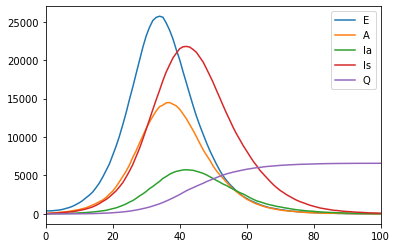

In [5]:
# plot the stochastic solution 
plt.plot(np.sum(data_array[:, M:2*M], axis=1), label='E')
plt.plot(np.sum(data_array[:, 2*M:3*M], axis=1), label='A')
plt.plot(np.sum(data_array[:, 3*M:4*M], axis=1), label='Ia')
plt.plot(np.sum(data_array[:, 4*M:5*M], axis=1), label='Is')
plt.plot(np.sum(data_array[:, 5*M:6*M], axis=1), label='Q')
plt.xlim([0, Tf])
plt.legend()
plt.show()

In [5]:
# new testing rates, all other parameters stay the same

tS    = 0.0            # rate S  -> Q
tE    = 0.02           # rate E  -> Q
tA    = 0.02           # rate A  -> Q
tIa   = 0.1           # rate Ia -> Q
tIs   = 0.5          # rate Is -> Q

t_interv=20

data_array = np.load('cal_seairq_traj.npy')

# set up new initial condition
S0  = data_array[t_interv,0:M]
E0  = data_array[t_interv,M:(2*M)]
A0  = data_array[t_interv,2*M:(3*M)]
Ia0 = data_array[t_interv,3*M:(4*M)] 
Is0 = data_array[t_interv,4*M:(5*M)] 
Q0  = data_array[t_interv,5*M:(6*M)] 
R0  = data_array[t_interv,6*M:(7*M)] 
R0  = Ni-(S0+E0+A0+Ia0+Is0+Q0)    

parameters2 = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs}

# use pyross stochastic to generate traj
sto_model = pyross.stochastic.SEAIRQ(parameters2, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, generator.constant_CM, Tf-t_interv, Nf-t_interv)
data_array2 = data['X']

# join trajectories and save
data_array_interv=data_array.copy()
data_array_interv[t_interv:,:]=data_array2.copy()
np.save('cal_seairq_traj_interv.npy', data_array_interv)

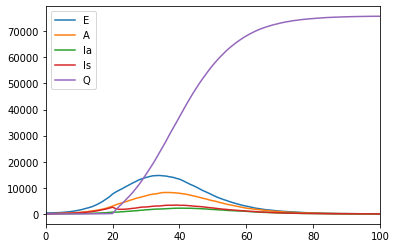

In [18]:
# plot the full trajectory 
data_array_interv = np.load('cal_seairq_traj_interv.npy')

plt.plot(np.sum(data_array_interv[:, M:2*M], axis=1), label='E')
plt.plot(np.sum(data_array_interv[:, 2*M:3*M], axis=1), label='A')
plt.plot(np.sum(data_array_interv[:, 3*M:4*M], axis=1), label='Ia')
plt.plot(np.sum(data_array_interv[:, 4*M:5*M], axis=1), label='Is')
plt.plot(np.sum(data_array_interv[:, 5*M:6*M], axis=1), label='Q')
plt.xlim([0, Tf])
plt.legend()
plt.show()

## 2) Infer the parameters of the model

In [7]:
data_array_interv = np.load('cal_seairq_traj_interv.npy')

Tf_inference=t_interv-1
Nf_inference=Tf_inference+1
x = data_array_interv[:Nf_inference]
x = (x/N) ## rescale by population size
steps = 101 ## number internal integration steps taken, must be an odd number 


## Initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

## Compute -log_p for the original (correct) parameters 
tS    = 0.0            # rate S  -> Q
tE    = 0.0           # rate E  -> Q
tA    = 0.0           # rate A  -> Q
tIa   = 0.0           # rate Ia -> Q
tIs   = 0.01           # rate Is -> Q
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs}

logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, generator.constant_CM)
print('The neg log-posterior at the correct parameter values is ', logp) 

The neg log-posterior at the correct parameter values is  -4106.861389715772


In [13]:
eps = 1e-4 

alpha_g = 0.3         
alpha_std = 0.1
alpha_b = (eps, 0.5)

beta_g  = 0.05        
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.25
gE_std = 0.1
gE_b = (eps, 0.5)

gA_g    = 0.3 
gA_std = 0.1
gA_b = (eps, 0.5) 
   

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
                   
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]) 
                   
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std]) 
            
start_time = time.time()
params = estimator.inference(guess, stds, x, Tf_inference, Nf_inference, 
                                    generator.constant_CM, bounds=bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=956842, Thu May  7 21:35:51 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.433357966540191e+03 1.0e+00 8.44e-01  4e-02  8e-02 0:18.6
    2     32 -3.785651407536379e+03 1.3e+00 7.38e-01  4e-02  7e-02 0:34.9
    3     48 -3.628971060718511e+03 1.5e+00 7.08e-01  3e-02  7e-02 0:51.9
    4     64 -3.078476979095553e+03 1.6e+00 6.43e-01  3e-02  6e-02 1:08.1
    5     80 -3.402316347841498e+03 1.9e+00 6.32e-01  3e-02  6e-02 1:24.8
    6     96 -3.608493706242206e+03 2.1e+00 6.93e-01  3e-02  7e-02 1:41.4
    7    112 -2.943658464946704e+03 2.4e+00 7.08e-01  3e-02  8e-02 1:57.3
    8    128 -3.496720060733123e+03 3.2e+00 7.41e-01  2e-02  9e-02 2:12.8
    9    144 -3.829646608374130e+03 4.4e+00 6.63e-01  2e-02  8e-02 2:31.5
   10    160 -3.960408346177064e+03 5.0e+00 6.47e-01  2e-02  9e-02 2:49.7
   11    176 -3.875222004100951e+03 5.9e+00 6.15e-01  1e-02  9e-0

In [14]:
# save the parameters 
np.save('SEAIRQ_cali_param.npy', params)

In [15]:
print('True parameters')
print(parameters)

params = np.load('SEAIRQ_cali_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

True parameters
{'alpha': 0.2, 'beta': 0.05, 'gE': 0.2, 'gA': 0.3333333333333333, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8, 'tS': 0.0, 'tE': 0.02, 'tA': 0.02, 'tIa': 0.1, 'tIs': 0.5}

 Best estimates
{'alpha': 0.2700469917985581, 'beta': 0.050068510654820854, 'gIa': 0.22629020265563232, 'gIs': 0.11220618783840912, 'gE': 0.19514770868761225, 'gA': 0.33720787890443416, 'fsa': 0.8, 'tS': 0, 'tE': 0.0, 'tA': 0.0, 'tIa': 0.0, 'tIs': 0.01}


## 3) Infer the new testing rates after intervention

In [20]:
data_array_interv = np.load('cal_seairq_traj_interv.npy')

x = data_array_interv[t_interv:]
x = (x/N) ## rescale by population size
Nf_control = x.shape[0]
Tf_control = Nf_control - 1


## Compute -log_p for the original (correct) testing rates 
best_estimates['tE'] = tE 
best_estimates['tA'] = tA 
best_estimates['tIa'] = tIa
best_estimates['tIs'] = tIs
logp = estimator.obtain_minus_log_p(best_estimates, x, Tf_control, Nf_control, generator.constant_CM)
print('The neg log-posterior at the correct parameter values is ', logp) 

The neg log-posterior at the correct parameter values is  -15820.19721555136


In [10]:
eps = 1e-4 

tE_g=0.03
tE_std=0.02
tE_bounds=(eps,0.1)

tA_g=0.01
tA_std = 0.02
tA_bounds=(eps,0.1)

tIa_g=0.08
tIa_std = 0.1
tIa_bounds=(eps,1)

tIs_g=0.4
tIs_std = 0.2 
tIs_bounds=(eps,1)

# fit only testing rates and take everything else as given


guess = np.array([tE_g, tA_g, tIa_g, tIs_g])
std = np.array([tE_std, tA_std, tIa_std, tIs_std])
bounds = np.array([tE_bounds, tA_bounds, tIa_bounds, tIs_bounds])

start_time = time.time() 

estimator.set_params(best_estimates) 
params = estimator.infer_control(guess, std, x, Tf_control, Nf_control, generator, bounds,
                                 global_max_iter=20, verbose=True)
end_time = time.time()

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=1027637, Thu May  7 22:02:14 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.230485389034070e+02 1.0e+00 1.14e+00  2e-02  2e-01 1:28.9
    2     32 -6.163086990344839e+02 1.8e+00 1.33e+00  2e-02  2e-01 3:02.0
    3     48 2.188786082290170e+02 2.7e+00 1.63e+00  3e-02  2e-01 4:36.7
    4     64 4.581243251139056e+03 3.7e+00 1.53e+00  3e-02  2e-01 6:09.1
    5     80 -1.302739512927467e+03 4.3e+00 1.36e+00  2e-02  2e-01 7:40.9
    6     96 -5.145303350072449e+03 5.0e+00 1.17e+00  2e-02  2e-01 9:13.3
    7    112 2.109063619830542e+03 5.3e+00 1.22e+00  2e-02  2e-01 10:41.3
    8    128 -5.959848200015843e+03 5.7e+00 1.18e+00  2e-02  1e-01 12:07.1
    9    144 -6.883378422861974e+03 5.9e+00 1.29e+00  2e-02  2e-01 13:27.0
   10    160 -7.922433680998814e+03 7.3e+00 1.33e+00  2e-02  2e-01 14:49.3
   11    176 -7.183596150099605e+03 6.3e+00 1.55e+00  2e-02  2e

In [13]:
print("True testing ratess:")
print([tE, tA, tIa, tIs])

print("\nInferred testing rates:")
print(params)

True testing ratess:
[0.02, 0.02, 0.1, 0.5]

Inferred testing rates:
[0.02164069 0.02053813 0.10724961 0.48994621]
